<a href="https://colab.research.google.com/github/bacetiner/BRAILS/blob/master/notebooks/BRAILS_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

If you are running this on Colab, please make sure to change your Runtime Type to GPU.

## Import required packages:


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random
import shutil

## Install the latest version of BRAILS:

In [ ]:
!pip install git+https://github.com/NHERI-SimCenter/BRAILS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/NHERI-SimCenter/BRAILS to /tmp/pip-req-build-ib3mhz71
  Running command git clone -q https://github.com/NHERI-SimCenter/BRAILS /tmp/pip-req-build-ib3mhz71
     |████████████████████████████████| 125 kB 7.4 MB/s 
     |████████████████████████████████| 512 kB 52.7 MB/s 
  Created wheel for BRAILS: filename=BRAILS-2.0.1.dev415+gca5d8fb-py3-none-any.whl size=9149835 sha256=7dfbf9e77a5eccb047e9a54ab5461f83aec189da32aa6fb4f854bc3257260edb
  Stored in directory: /tmp/pip-ephem-wheel-cache-vaadjt97/wheels/95/f4/e3/a6a0d6655270cc9295155895448d84860de3e7b8a1f4fa8840
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=a524715c216cfe1f19581cdabec84e57aeb7c1ef0a2a5c583f51bb324baa309b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built BRAILS wget


## Download PEER Hub ImageNet Φ-Net Data for Building Collapse Mode
For general info on the dataset please visit: https://apps.peer.berkeley.edu/phi-net/download/

The download link for the data: https://apps.peer.berkeley.edu/phichallenge/dataset/3ddwa5567



In [ ]:
!wget -O data.zip https://apps.peer.berkeley.edu/phichallenge/dataset/3ddwa5567
!unzip data.zip

--2022-07-26 21:13:34--  https://apps.peer.berkeley.edu/phichallenge/dataset/3ddwa5567
Resolving apps.peer.berkeley.edu (apps.peer.berkeley.edu)... 128.32.143.24, 2607:f140:0:f::24
Connecting to apps.peer.berkeley.edu (apps.peer.berkeley.edu)|128.32.143.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://apps.peer.berkeley.edu/phichallenge/dataset/task5_collapse_mode.zip [following]
--2022-07-26 21:13:35--  https://apps.peer.berkeley.edu/phichallenge/dataset/task5_collapse_mode.zip
Reusing existing connection to apps.peer.berkeley.edu:443.
HTTP request sent, awaiting response... 200 OK
Length: 232967101 (222M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 222.17M   142MB/s    in 1.6s    

2022-07-26 21:13:36 (142 MB/s) - ‘data.zip’ saved [232967101/232967101]

Archive:  data.zip
   creating: task5/
  inflating: task5/task5_X_test.npy  
  inflating: task5/task5_y_test.npy  
  inflating: task5/task5_X_train.n

##Preprocess Φ-Net Data:
Φ-Net stores image data as a one big numpy array. These images are saved in BGR format and need to be normalized to convert into the correct RGB format.

BRAILS expects training data in the following format

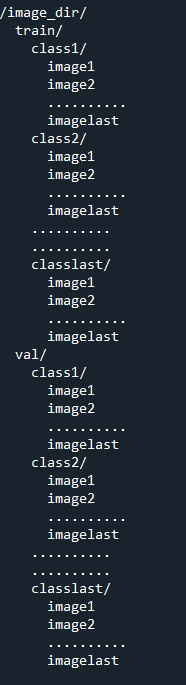

The following code parses the raw Φ-Net Data into this format.

In [ ]:
datadir = 'task5/'            # Root directory the Numpy files are stored 
classes = ['GC', 'NC', 'PC']  # Classes corresponding to the labels in the Numpy files
                              # GC: Global collapse, NC: No collapse, PC: Partial collapse

for phase in ['train', 'val']:
    for cl in classes: 
        os.makedirs(datadir + f'data/{phase}/{cl}',exist_ok=True)
        os.makedirs(datadir + f'data/{phase}/{cl}',exist_ok=True)
    if phase=='val':
        phasew = 'test'
    else:
        phasew = 'train'
    ims = np.load(datadir + f'task5_X_{phasew}.npy')
    maxpix = np.amax(ims)
    minpix = np.amin(ims)
    labels = np.load(datadir + f'task5_y_{phasew}.npy')
    labels[:,1]*=2
    labels[:,2]*=3
    labels = (labels[np.where(labels!=0)] - 1).astype(int)
    for im in range(0,len(ims)):
            img = ((ims[im,:,:,:]) - minpix)*255/(maxpix - minpix)
            cl = classes[labels[im]]
            cv2.imwrite(datadir + f'data/{phase}/{cl}/{im}.jpg', img)

## Call BRAILS ImageClassifier to train a classifier model:

**ImageClassifier(modelArch="efficientnetv2s")** initiates the classifier model class object with a classifer architecture. Available architectures are ResNet18, EfficientNet_v2 (small, medium, large), ConvNext (small, base, large), RegNet (16, 32), and Vision Transformer (ViT14, ViT16)

**ImageClassifier.train(trainDataDir='tmp/hymenoptera_data', batchSize=8, nepochs=100)** trains a classifier model for a defined trainDataDir, training batch size and number of epochs.

**ImageClassifier.retrain(modelPath=tmp/models/trained_model.pth,trainDataDir='tmp/hymenoptera_data', batchSize=8, nepochs=100)** further finetunes a classifier model for a defined trainDataDir, training batch size and number of epochs. The defined model in modelPath and the training data in trainDataDir must be compatible to use this method.

In [ ]:
from brails.modules import ImageClassifier
imClassifier = ImageClassifier()
imClassifier.train(trainDataDir='task5/data',nepochs=20)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


  0%|          | 0.00/82.7M [00:00<?, ?B/s]

Epoch 0/9
----------
Train Loss: 0.9613 Acc: 0.5285
Val Loss: 0.7237 Acc: 0.6712

Epoch 1/9
----------
Train Loss: 0.7920 Acc: 0.6281
Val Loss: 0.6882 Acc: 0.7466

Epoch 2/9
----------
Train Loss: 0.7130 Acc: 0.6892
Val Loss: 0.6671 Acc: 0.6918

Epoch 3/9
----------
Train Loss: 0.6857 Acc: 0.6941
Val Loss: 0.6338 Acc: 0.6986

Epoch 4/9
----------
Train Loss: 0.6718 Acc: 0.7007
Val Loss: 0.6262 Acc: 0.7055

Epoch 5/9
----------
Train Loss: 0.6299 Acc: 0.7202
Val Loss: 0.6175 Acc: 0.7603

Epoch 6/9
----------
Train Loss: 0.6221 Acc: 0.7325
Val Loss: 0.6123 Acc: 0.7123

Epoch 7/9
----------
Train Loss: 0.5362 Acc: 0.7863
Val Loss: 0.6275 Acc: 0.7192

Epoch 8/9
----------
Train Loss: 0.5166 Acc: 0.7708
Val Loss: 0.6263 Acc: 0.7466

Epoch 9/9
----------
Train Loss: 0.4870 Acc: 0.8010
Val Loss: 0.6914 Acc: 0.7466

Best val Acc: 0.760274
Elapsed time: 5m 17s
New classifier head trained using transfer learning.

Fine-tuning the model...
Epoch 0/9
----------
Train Loss: 0.5724 Acc: 0.7659
Val L

## Plot the change in validation accuracy over training epochs:

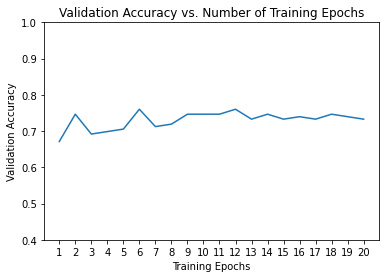

In [ ]:
%matplotlib inline
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,len(imClassifier.lossHistory)+1),imClassifier.lossHistory)
plt.ylim((0.4,1.))
plt.xticks(np.arange(1, len(imClassifier.lossHistory)+1, 1.0))
plt.show()

## Randomly select a number of samples from each class to see how well we predict:
**predict(modelPath='tmp/models/trained_model.pth', 
                testDataDir='tmp/hymenoptera_data/val/ants',
                classes=['Ants','Bees'])** loads the model in modelPath and uses this model to predict the classes for the image data in testDataDir using the labels listed in classes. The folder structure for testDataDir must be the same as the structure for trainDataDir

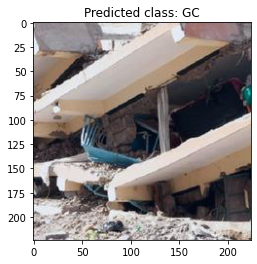

Predicted class: GC
Actual class: GC


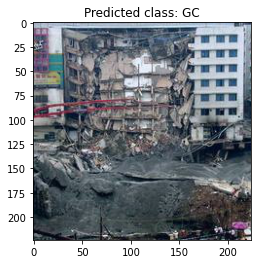

Predicted class: GC
Actual class: GC


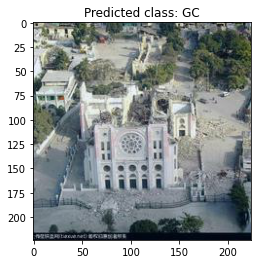

Predicted class: GC
Actual class: GC


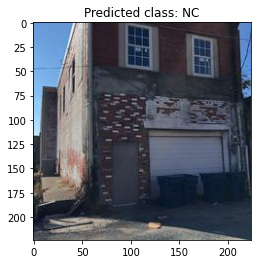

Predicted class: NC
Actual class: NC


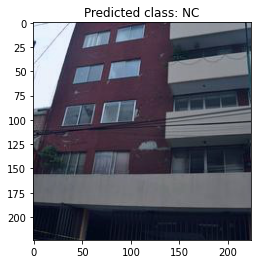

Predicted class: NC
Actual class: NC


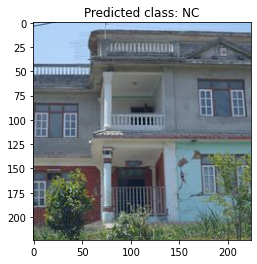

Predicted class: NC
Actual class: NC


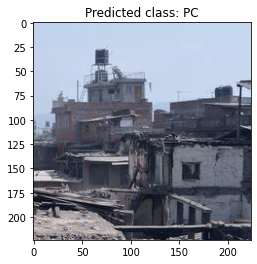

Predicted class: PC
Actual class: PC


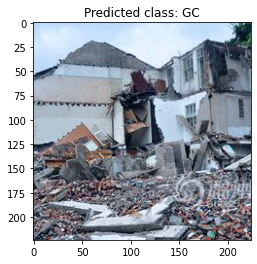

Predicted class: GC
Actual class: PC


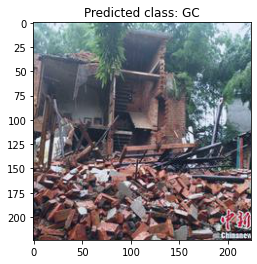

Predicted class: GC
Actual class: PC


In [ ]:
nsamples = 3
for cl in  classes:
    ims = os.listdir(datadir+f'data/val/{cl}')
    samples = random.sample(ims,nsamples)
    for sample in samples:
        imClassifier.predict(testDataDir=datadir+f'data/val/{cl}/{sample}',
                                                  classes=classes)
        print(f'Actual class: {cl}')

## View the number of training samples for each class:

In [ ]:
im = os.listdir('task5/data/train/GC')
print(f'GC: {len(im)}')
im = os.listdir('task5/data/train/NC')
print(f'NC: {len(im)}')
im = os.listdir('task5/data/train/PC')
print(f'PC: {len(im)}')

GC: 525
NC: 322
PC: 379


## Create a balanced training dataset from the original set:

In [ ]:
nsamples = 322
for cl in classes:
    dir = f'task5/data_reduced/train/{cl}'
    os.makedirs(dir,exist_ok=True)
    ims = os.listdir(f'task5/data/train/{cl}')
    ims_red = random.sample(ims,nsamples)
    for im in ims_red:
      shutil.copyfile(f'task5/data/train/{cl}/{im}', f'task5/data_reduced/train/{cl}/{im}')
shutil.copytree('task5/data/val','task5/data_reduced/val')

## View the number of training samples for each class in the balanced set:

In [ ]:
im = os.listdir('task5/data_reduced/train/GC')
print(f'GC: {len(im)}')
im = os.listdir('task5/data_reduced/train/NC')
print(f'NC: {len(im)}')
im = os.listdir('task5/data_reduced/train/PC')
print(f'PC: {len(im)}')

GC: 322
NC: 322
PC: 322


## Further train the previous model using the balanced dataset:

Epoch 0/9
----------
Train Loss: 0.6312 Acc: 0.7288
Val Loss: 0.5940 Acc: 0.7397

Epoch 1/9
----------
Train Loss: 0.5911 Acc: 0.7505
Val Loss: 0.6053 Acc: 0.7123

Epoch 2/9
----------
Train Loss: 0.5649 Acc: 0.7681
Val Loss: 0.6105 Acc: 0.7466

Epoch 3/9
----------
Train Loss: 0.5916 Acc: 0.7371
Val Loss: 0.6212 Acc: 0.7466

Epoch 4/9
----------
Train Loss: 0.5699 Acc: 0.7557
Val Loss: 0.6029 Acc: 0.7397

Epoch 5/9
----------
Train Loss: 0.5316 Acc: 0.7754
Val Loss: 0.6203 Acc: 0.7397

Epoch 6/9
----------
Train Loss: 0.5485 Acc: 0.7609
Val Loss: 0.6235 Acc: 0.7329

Epoch 7/9
----------
Train Loss: 0.5311 Acc: 0.7640
Val Loss: 0.6351 Acc: 0.7123

Epoch 8/9
----------
Train Loss: 0.5259 Acc: 0.7805
Val Loss: 0.6513 Acc: 0.7192

Epoch 9/9
----------
Train Loss: 0.5388 Acc: 0.7702
Val Loss: 0.6323 Acc: 0.7123

Best val Acc: 0.746575
Elapsed time: 4m 13s
Training complete.


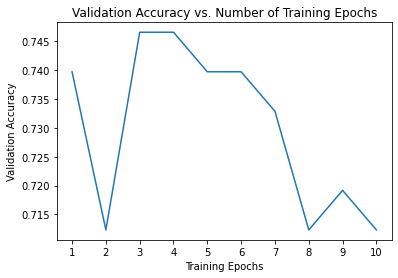

In [ ]:
imClassifier.retrain(trainDataDir='task5/data_reduced',nepochs=10)